<img src="https://raw.githubusercontent.com/raimundo1994/logos/main/logo_gravmag.png" alt="logo" style="max-width: 450px;display: block">

<h1 style="text-align: center; font-size: 3rem;">Processamento e interpretação de
dados de campos potenciais  </h1>

<h1 style="text-align: center; font-size: 2.0rem;">Processando dados Magnéticos </h1>

## ℹ️ Sobre este tutorial


Neste tutorial, vamos aplicar a redução ao polo nos dados de magnéticos na Região de Carajá - Pará - Brasil

## 🐍 Importe as bibliotecas necessárias

In [1]:
import numpy as np
import xarray as xr
import verde as vd
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import griddata
from codes import functions as func
from codes import interpolate as mpl
import harmonica as hm
import pyproj

C:\Users\oscar\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
from codes.gravmag import filters, convolve, transforms

In [3]:
from matplotlib import rcParams
rcParams["figure.dpi"] = 150

## Carrega os dados

In [4]:
header = ['X', 'Y', 'Long', 'Lat', 'Tfa', 'F']

In [5]:
#São seis canais e uma delimitação de abas. Além disso, temos que pular uma única linha.
data = pd.read_csv('dados/carajas_mag.XYZ',
                   sep='\s+',
                   skiprows=1,
                   names=header)
data

,X,Y,Long,Lat,Tfa,F
0,415901.0,9668886.0,-51.75677,-2.99539,16.0,27413.0
1,415901.0,9668826.0,-51.75677,-2.99593,16.0,27412.0
2,415901.0,9668768.0,-51.75677,-2.99646,13.0,27409.0
3,415901.0,9668708.0,-51.75677,-2.99700,8.0,27404.0
4,415901.0,9668648.0,-51.75677,-2.99755,2.0,27398.0
...,...,...,...,...,...,...
269842,409674.0,9663404.0,-51.81285,-3.04494,48.0,27432.0
269843,409614.0,9663404.0,-51.81338,-3.04494,49.0,27433.0
269844,409553.0,9663404.0,-51.81393,-3.04494,55.0,27439.0
269845,409493.0,9663404.0,-51.81448,-3.04494,55.0,27439.0


In [6]:
# Define a área
geografic_area = (data.Long.min(), data.Long.max(), data.Lat.min(), data.Lat.max())
projected_area = (data.X.min(), data.X.max(), data.Y.min(), data.Y.max())

In [7]:
print ('Study area (degrees):', np.round(geografic_area, decimals = 3))
print 
print ('Study area (meters):', np.round(projected_area, decimals = 2))

Study area (degrees): [-51.815 -49.475  -4.03   -2.921]
Study area (meters): [ 409432.  669346. 9554600. 9677098.]


In [8]:
# Defina os valores mínimo e máximo
longmin = np.round(data.Long.min(), decimals = 2)
longmax = np.round(data.Long.max(), decimals = 2)
latmin = np.round(data.Lat.min(), decimals = 2)
latmax = np.round(data.Lat.max(), decimals = 2)

In [9]:
# Analizando os dados de anomalia de campo total
print ('Dados de anomalia de campo total:')
print ('Min:', data.Tfa.min())
print ('Max:', data.Tfa.max())

Dados de anomalia de campo total:
Min: -4230.0
Max: 878.0


In [10]:
# Analizando os dados de campo total 
print ('Dados de campo total :')
print ('Min:', data.F.min())
print ('Max:', data.F.max())

Dados de campo total :
Min: 23037.0
Max: 28142.0


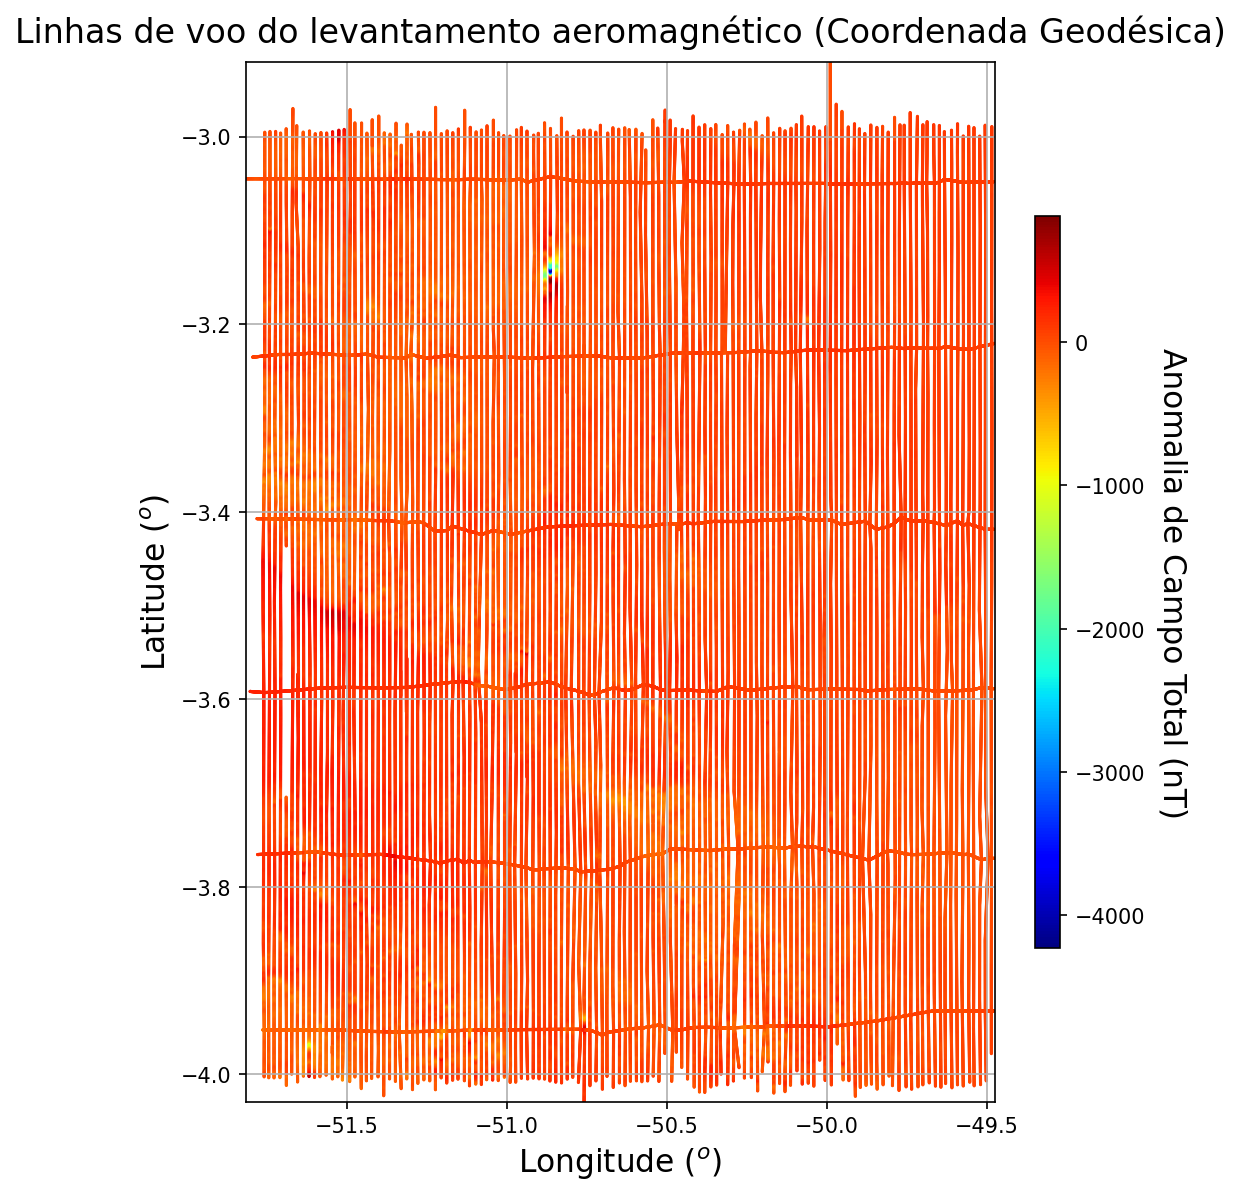

In [11]:
figure1 = plt.figure(figsize=(7,9))

p1 = plt.scatter(data.Long, data.Lat, s = 1., c = data.Tfa, marker = '.', cmap = 'jet')
cbar1 = plt.colorbar(p1, aspect = 30, fraction = 0.03, orientation = 'vertical')
cbar1.set_label('Anomalia de Campo Total (nT)',fontsize = 15, rotation = -90, labelpad = 20)

plt.title('Linhas de voo do levantamento aeromagnético (Coordenada Geodésica)',fontsize = 16, pad = 10)
plt.xlabel('Longitude ($^o$)', fontsize = 15)
plt.ylabel('Latitude ($^o$)', fontsize = 15)
plt.xlim(data.Long.min(), data.Long.max())
plt.ylim(data.Lat.min(), data.Lat.max())

# plt.savefig('figure01-flight-lines.png', dpi = 300, transparence = True, bbox_inches = 'tight')
# plt.savefig('figure01-flight-lines.pdf', dpi = 300, transparence = True, bbox_inches = 'tight')
plt.grid()
plt.show()

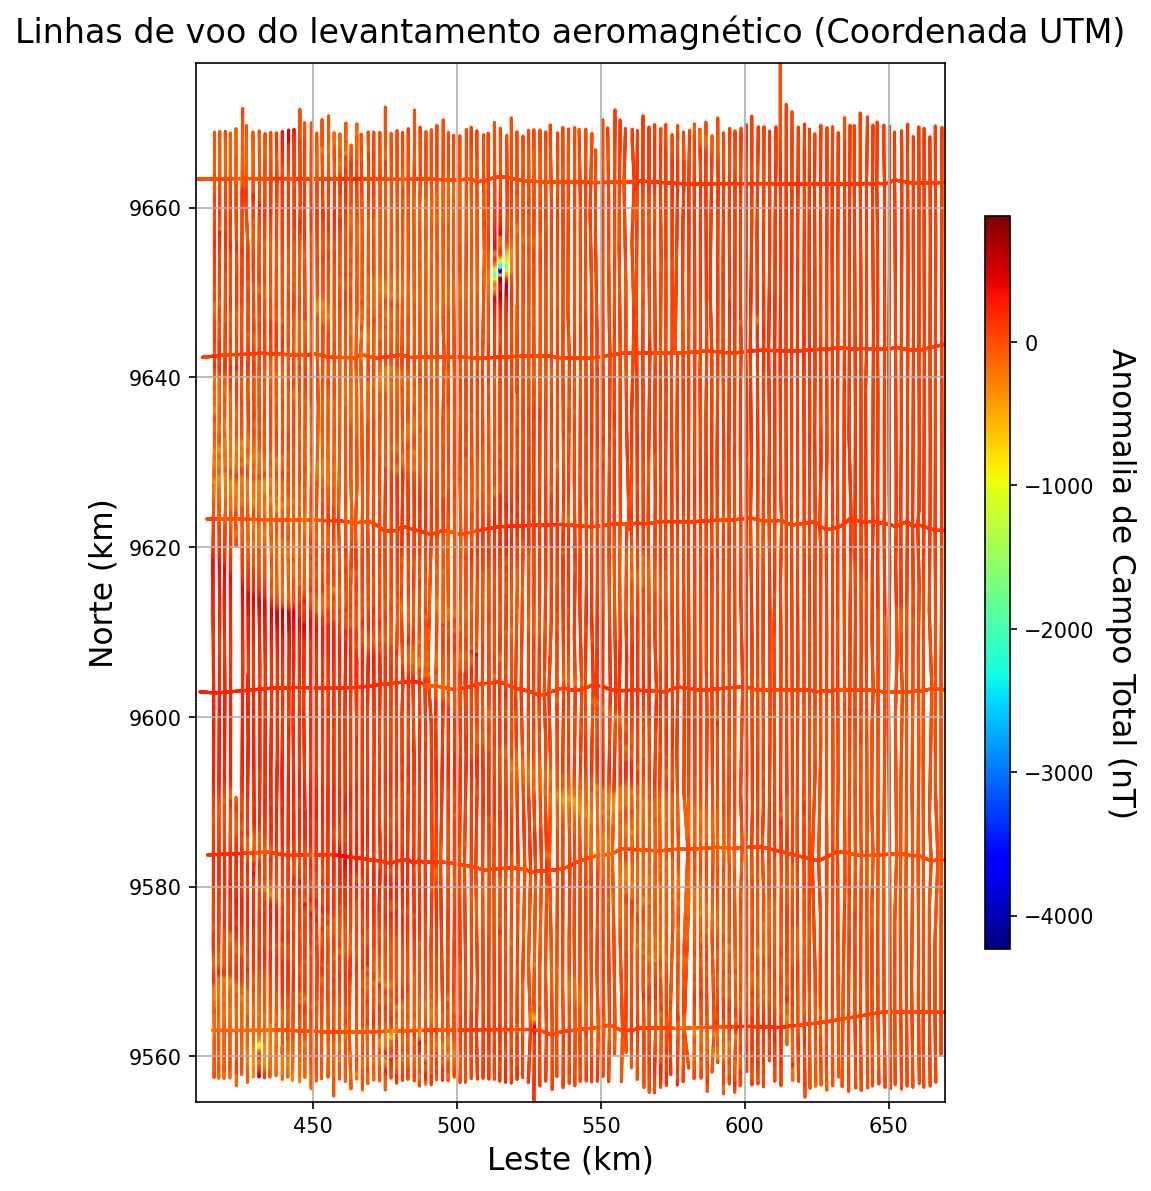

In [12]:
figure1 = plt.figure(figsize=(7,9))

p1 = plt.scatter(data.X*0.001, data.Y*0.001, s = 1., c = data.Tfa, marker = '.', cmap = 'jet')
cbar1 = plt.colorbar(p1, aspect = 30, fraction = 0.03, orientation = 'vertical')
cbar1.set_label('Anomalia de Campo Total (nT)',fontsize = 15, rotation = -90, labelpad = 20)

plt.title('Linhas de voo do levantamento aeromagnético (Coordenada UTM)',fontsize = 16, pad = 10)
plt.xlabel('Leste (km)', fontsize = 15)
plt.ylabel('Norte (km)', fontsize = 15)
plt.xlim(data.X.min()*0.001, data.X.max()*0.001)
plt.ylim(data.Y.min()*0.001, data.Y.max()*0.001)

# plt.savefig('figure01-flight-lines.png', dpi = 300, transparence = True, bbox_inches = 'tight')
# plt.savefig('figure01-flight-lines.pdf', dpi = 300, transparence = True, bbox_inches = 'tight')
plt.grid()
plt.show()

## Corte o conjunto de dados em uma região menor

In [13]:
# Defina a região a ser cortada ([W, E, S, N]):
region_deg = (-52,-50,-3.2,-3.1)

In [14]:
# Obtenha uma matriz com as coordenadas do conjunto de dados que estão dentro do region_cut: 
inside = vd.inside((data.Long, data.Lat), region_deg)
# Obtenha um conjunto de dados menor e substitua-o no original:
data = data[inside]
data

,X,Y,Long,Lat,Tfa,F
195,415901.0,9657318.0,-51.75685,-3.10004,95.0,27455.0
196,415901.0,9657260.0,-51.75685,-3.10056,97.0,27457.0
197,415901.0,9657200.0,-51.75685,-3.10111,98.0,27458.0
198,415901.0,9657140.0,-51.75685,-3.10165,100.0,27460.0
199,415901.0,9657082.0,-51.75685,-3.10217,101.0,27460.0
...,...,...,...,...,...,...
186894,610443.0,9646492.0,-50.00600,-3.19777,170.0,27349.0
186895,610442.0,9646432.0,-50.00600,-3.19831,171.0,27350.0
186896,610441.0,9646372.0,-50.00601,-3.19886,171.0,27350.0
186897,610439.0,9646312.0,-50.00603,-3.19940,172.0,27351.0


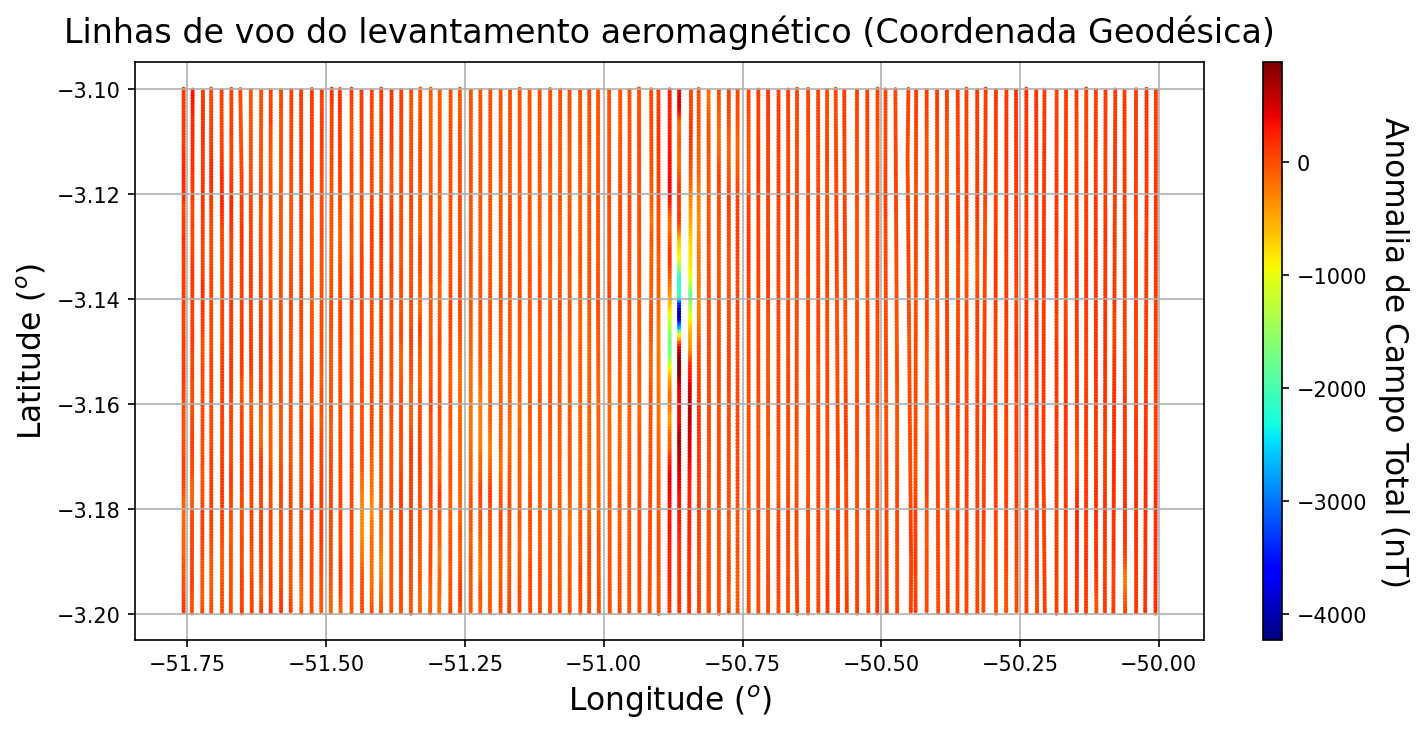

In [15]:
figure1 = plt.figure(figsize=(10,5))

p1 = plt.scatter(data.Long, data.Lat, s = 4., c = data.Tfa, marker = '.', cmap = 'jet')
cbar1 = plt.colorbar(p1, aspect = 30, fraction = 0.03, orientation = 'vertical')
cbar1.set_label('Anomalia de Campo Total (nT)',fontsize = 15, rotation = -90, labelpad = 20)

plt.title('Linhas de voo do levantamento aeromagnético (Coordenada Geodésica)',fontsize = 16, pad = 10)
plt.xlabel('Longitude ($^o$)', fontsize = 15)
plt.ylabel('Latitude ($^o$)', fontsize = 15)
# plt.xlim(data.Long.min(), data.Long.max())
# plt.ylim(data.Lat.min(), data.Lat.max())

# plt.savefig('figure01-flight-lines.png', dpi = 300, transparence = True, bbox_inches = 'tight')
# plt.savefig('figure01-flight-lines.pdf', dpi = 300, transparence = True, bbox_inches = 'tight')
plt.grid()
plt.show()

## Interpolar os dados

In [16]:
# Defina os valores mínimo e máximo
longmin = np.round(data.Long.min(), decimals = 2)
longmax = np.round(data.Long.max(), decimals = 2)
latmin = np.round(data.Lat.min(), decimals = 2)
latmax = np.round(data.Lat.max(), decimals = 2)

In [17]:
# Analizando os dados de anomalia de campo total
print ('Dados de anomalia de campo total:')
print ('Min:', data.Tfa.min())
print ('Max:', data.Tfa.max())

Dados de anomalia de campo total:
Min: -4230.0
Max: 878.0


In [18]:
# Define o numero de pontos e shape
num = 500
longitude = np.linspace(longmin, longmax, num)
latitude = np.linspace(latmin, latmax, num)

In [19]:
# Cria o grid
gridlong, gridlat = np.meshgrid(longitude, latitude)

In [20]:
flightcoordinates = (data.Long, data.Lat)
gridcoordinates = (gridlong, gridlat)

In [21]:
# Interpolar os dados de anomalia de campo total
Tfi = griddata(flightcoordinates, data.Tfa, gridcoordinates, method = 'cubic')
np.savetxt("dados/tfi.txt",Tfi.ravel().T)

In [22]:
vtfmin = data.Tfa.min()
vtfmax = data.Tfa.max()

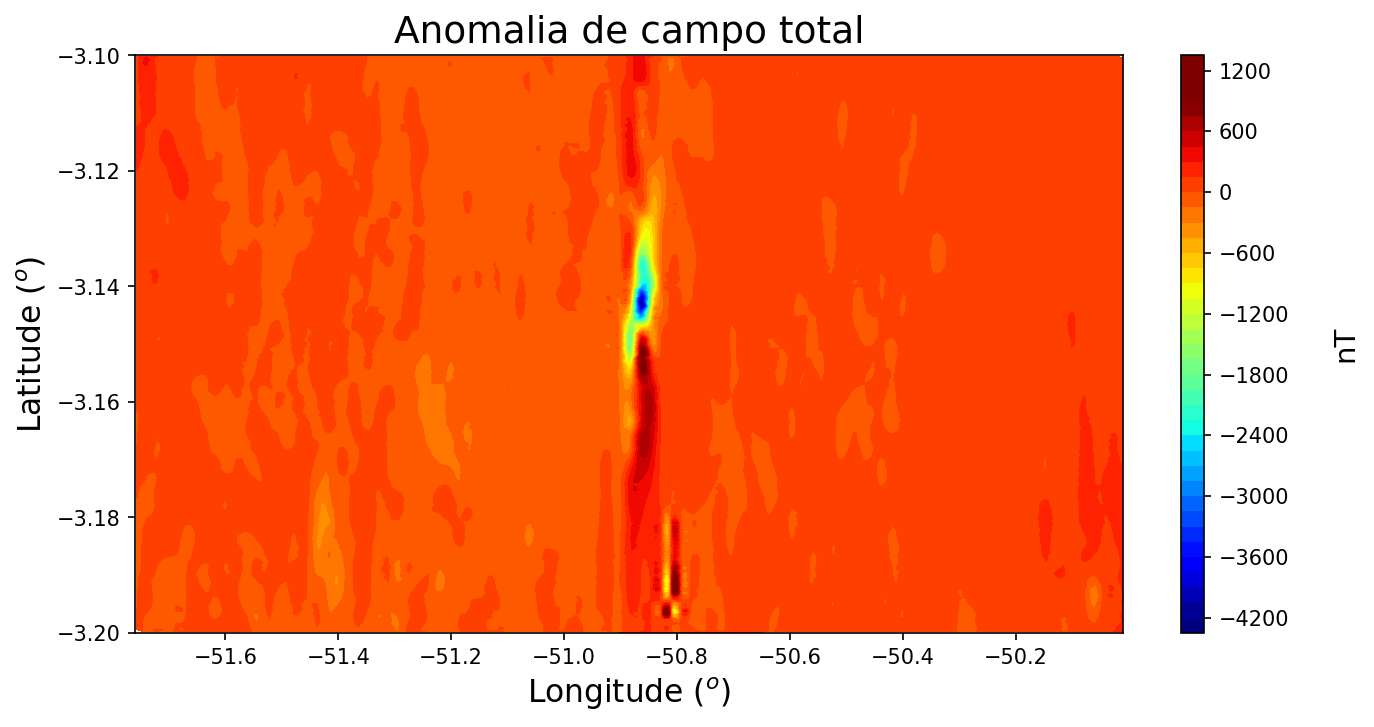

In [25]:
# Visualizando dado interpolado
plt.close('all')
fig01 = plt.figure(figsize=(10,5))
ranges = np.max(np.abs([Tfi]))

image1 = plt.contourf(gridlong, gridlat, Tfi, 50,
                      vmin = vtfmin, vmax = vtfmax, cmap = plt.cm.jet)
cbar1 = plt.colorbar(image1, aspect = 25, fraction = 0.1, orientation = 'vertical')
cbar1.set_label('nT', fontsize = 14, rotation = 90, labelpad = 20)

plt.title('Anomalia de campo total', fontsize = 18)
plt.xlabel('Longitude ($^o$)', fontsize = 15)
plt.ylabel('Latitude ($^o$)', fontsize = 15)
plt.xlim(longmin, longmax)
plt.ylim(latmin, latmax)


plt.show()